An IPython notebook that explores the relationship(correlation) between betweenness centrality and community membership of a number of mailing-lists in a given time period.

In [142]:
%matplotlib inline

In [143]:
from bigbang.archive import Archive
import bigbang.parse as parse
import bigbang.analysis.graph as graph
import bigbang.ingress.mailman as mailman
import bigbang.analysis.process as process
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz
import numpy as np
import math
from itertools import repeat

In [172]:
urls = [
    "https://mm.icann.org/pipermail/cc-humanrights/",
    "http://mm.icann.org/pipermail/future-challenges/",
]


archives = [Archive(url, archive_dir="../archives") for url in urls]

The following sets start month and end month, both inclusive.

In [199]:
min_date = []
max_date = []
for arch in archives:
    if min_date == [] and max_date == []:
        max_date = max(arch.data["Date"])
        min_date = min(arch.data["Date"])
    else:
        if max(arch.data["Date"]) > max_date:
            max_date = max_date = max(arch.data["Date"])
        if min(arch.data["Date"]) < min_date:
            min_date = min_date = min(arch.data["Date"])
max_date = [int(str(max_date)[:4]), int(str(max_date)[5:7])]
min_date = [int(str(min_date)[:4]), int(str(min_date)[5:7])]
date_from_whole = [
    2015,
    7,
]  # min_date #set date_from_whole based on actual time frame in mailing lists
date_to_whole = max_date  # set date_to_whole based on actual time fram in mailing lists
print(date_from_whole)
print(date_to_whole)
total_month = (date_to_whole[0] - date_from_whole[0]) * 12 + (
    date_to_whole[1] - date_from_whole[1] + 1
)

[2015, 7]
[2016, 6]


In [200]:
date_from = []
date_to = []
temp_year = date_from_whole[0]
temp_month = date_from_whole[1]

for i in range(total_month):
    date_from.append(pd.datetime(temp_year, temp_month, 1, tzinfo=pytz.utc))
    if temp_month == 12:
        temp_year += 1
        temp_month = 0
    date_to.append(pd.datetime(temp_year, temp_month + 1, 1, tzinfo=pytz.utc))
    temp_month += 1

In [201]:
def filter_by_date(df, d_from, d_to):
    return df[(df["Date"] > d_from) & (df["Date"] < d_to)]

In [202]:
IG = []
for k in range(total_month):
    dfs = [filter_by_date(arx.data, date_from[k], date_to[k]) for arx in archives]
    bdf = pd.concat(dfs)
    IG.append(graph.messages_to_interaction_graph(bdf))


# RG = graph.messages_to_reply_graph(messages)

# IG = graph.messages_to_interaction_graph(bdf)

In [203]:
print(len(bdf))
bc = []
for j in range(total_month):
    bc.append(pd.Series(nx.betweenness_centrality(IG[j])))

32


In [204]:
len(bc)

12

new_dict is a dictionary with keys as users' names, and values of their community membership(can have different interpretation)
Here the community membership for a user is defined as sum of log(Ni + 1), with Ni corresponds to the number of emails a user sent to Mailing list i.

In [205]:
new_dict = [{} for i in repeat(None, total_month)]
new_dict1 = [{} for i in repeat(None, total_month)]
for t in range(total_month):
    filtered_activity = []
    for i in range(len(archives)):
        df = archives[i].data
        fdf = filter_by_date(df, date_from[t], date_to[t])
        if len(fdf) > 0:
            filtered_activity.append(Archive(fdf).get_activity().sum())
    for k in range(len(filtered_activity)):
        for g in range(len(filtered_activity[k])):
            original_key = list(filtered_activity[k].keys())[g]
            new_key = original_key[
                original_key.index("(") + 1 : original_key.rindex(")")
            ]
            if new_key not in new_dict[t]:
                new_dict[t][new_key] = 0
                new_dict1[t][new_key] = 0
            new_dict[t][new_key] += math.log(filtered_activity[k].get_values()[g] + 1)
            # can define community membership by changing the above line.
            # example, direct sum of emails would be
            new_dict1[t][new_key] += filtered_activity[k].get_values()[g]

                                                                                  From  \
Message-ID                                                                               
<559917FD.2090001@article19.org>              niels at article19.org (Niels ten Oever)   
<00e801d0ca3f$0c006fd0$24014f70$@dotgay.com>        jamie at dotgay.com (Jamie Baxter)   

                                                                                        Subject  \
Message-ID                                                                                        
<559917FD.2090001@article19.org>              [cc-humanrights] Overview of CCWP ICANN CSR & ...   
<00e801d0ca3f$0c006fd0$24014f70$@dotgay.com>              [cc-humanrights] ICANN site selection   

                                                            Date In-Reply-To  \
Message-ID                                                                     
<559917FD.2090001@article19.org>             2015-07-05 11:41:49        None   
<0

In [206]:
for i in range(len(new_dict1)):
    [x + 1 for x in list(new_dict1[i].values())]
    [np.log(x) for x in list(new_dict1[i].values())]

In [207]:
# check if there's name difference, return nothing if perfect.
for i in range(total_month):
    set(new_dict[i].keys()).difference(bc[i].index.values)
    set(bc[i].index.values).difference(list(new_dict[i].keys()))
    set(new_dict1[i].keys()).difference(bc[i].index.values)
    set(bc[i].index.values).difference(list(new_dict1[i].keys()))

In [208]:
# A list of corresponding betweenness centrality and community membership for all users, monthly
comparison = []
comparison1 = []
for i in range(len(new_dict)):
    comparison.append(pd.DataFrame([new_dict[i], bc[i]]))
    comparison1.append(pd.DataFrame([new_dict1[i], bc[i]]))

In [209]:
corr = []
corr1 = []
for i in range(len(new_dict)):
    corr.append(
        np.corrcoef(comparison[i].get_values()[0], comparison[i].get_values()[1])[0, 1]
    )
    corr1.append(
        np.corrcoef(comparison1[i].get_values()[0], comparison1[i].get_values()[1])[
            0, 1
        ]
    )

In [210]:
corr1

[nan,
 0.67116924610716644,
 0.91969985808305665,
 nan,
 0.71429809150866919,
 0.058925565098878974,
 0.90928975724399008,
 0.92589196595487244,
 0.74684797051608898,
 0.64535025445220628,
 0.93342682618228878,
 0.77463604714063594]

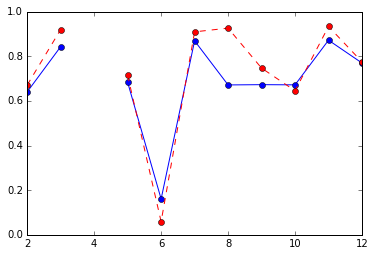

In [211]:
# Blue as sum of log, red as log of sum, respect to community membership
x = list(range(1, total_month + 1))
y = corr
plt.plot(x, y, marker="o")
z = corr1
plt.plot(x, z, marker="o", linestyle="--", color="r")